<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [109]:
import re
import string

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import squarify

import pandas as pd
import numpy as np

import spacy

import requests
from bs4 import BeautifulSoup

## 1) *Optional:* Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

In [87]:
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"

max_results_per_city = 10 

results = []

df = pd.DataFrame(columns=["Title", "Location", "Company", "Description"])

for city in set(['New+York', 'San+Francisco', 'Seattle', 'Los+Angeles', 'Denver',
                 'San+Diego', 'Sacramento', 'Arlington', 'Alexandria', 'Fairfax']):
    for start in range(0, max_results_per_city, 10):
        # Grab the results from the request (as above)
        url = url_template.format(city, start)
        # Append to the full set of results
        html = requests.get(url)
        soup = BeautifulSoup(html.content, 'html.parser', from_encoding="utf-8")
        for each in soup.find_all(class_="result")[:10]:
            try: 
                title = each.find(class_='jobtitle').text.replace('\n', '')
            except:
                title = None
            try:
                location = each.find(class_='location').text.replace('\n', '')
            except:
                location = None
            try: 
                company = each.find(class_='company').text.replace('\n', '')
            except:
                company = None
            try:
                synopsis = each.find(class_='summary').text.replace('\n', '')
            except:
                synopsis = None
            df = df.append({'Title':title, 'Location':location, 'Company':company, 'Description':synopsis}, ignore_index=True)

In [88]:
print(df.shape)
df.head()

(100, 4)


,Title,Location,Company,Description
0,Data Scientist,"San Francisco, CA",Seen by Indeed,Seen by Indeed is a free service that connects...
1,Data Scientist,"San Francisco, CA",Blue Owl,A million people a year die in car collisions ...
2,Data Scientist,"San Francisco, CA",Stanza,"Hundreds of millions of pageviews, natural lan..."
3,"Data Scientist, Solar","Larkspur, CA 94939",Power Factors,"We are Power Factors, developer of the world’s..."
4,"Principal Data Scientist, People Analytics","South San Francisco, CA 94083",Genentech,The People Analytics team at Genentech is a sm...


In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
Title          100 non-null object
Location       100 non-null object
Company        100 non-null object
Description    100 non-null object
tokens         100 non-null object
dtypes: object(5)
memory usage: 4.0+ KB


## 2) Use Spacy to tokenize / clean the listings 

In [219]:
nlp = spacy.load("en_core_web_lg")

tokenizer = spacy.tokenizer.Tokenizer(nlp.vocab)

tokens = []

for doc in tokenizer.pipe(df['Description'], batch_size=500):
    doc_tokens = [token.lemma_.lower() for token in doc if (token.is_stop != True) and (token.is_punct != True)]
    tokens.append(doc_tokens)

df['tokens'] = tokens

In [220]:
df['Description'][0]

"Seen by Indeed is a free service that connects qualified job-seekers (that's you) with top companies hiring tech roles."

In [221]:
for doc in tokenizer.pipe(df['Description'][:1], batch_size=500):
    doc_tokens = [token.lemma_.lower() for token in doc if (token.is_stop != True) and (token.is_punct != True)]
    print(doc_tokens)

['seen', 'free', 'service', 'connect', 'qualify', 'job-seekers', "(that's", 'you)', 'company', 'hire', 'tech', 'roles.']


In [222]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')
    
wc = count(df['tokens'])

wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
250,,50,50,1.0,0.033333,0.033333,0.50
91,data,31,36,2.0,0.024000,0.057333,0.31
58,datum,18,22,3.0,0.014667,0.072000,0.18
279,scientist,20,20,4.0,0.013333,0.085333,0.20
1,company,13,13,5.0,0.008667,0.094000,0.13


In [223]:
STOP_WORDS = nlp.Defaults.stop_words.union([' '])

In [224]:
tokens = []

for doc in tokenizer.pipe(df['Description'], batch_size=500):
    doc_tokens = [token.lemma_.lower() for token in doc if (token.text.lower() not in STOP_WORDS) and (token.is_punct != True)]
    tokens.append(doc_tokens)

df['tokens'] = tokens

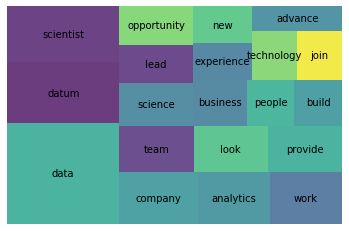

In [225]:
wc = count(df['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [231]:
vect = CountVectorizer(stop_words=STOP_WORDS, lowercase=False, tokenizer=lambda x:x)

doc = df['tokens'].tolist()

dtm = vect.fit_transform(doc)

dtm_df = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())

dtm_df.head()

//anaconda3/envs/U4-S1-NLP/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', '‘', '’'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,"(12076),",(ai),(bios).center,(cida).,(click,(co).this,(coe),(computer,(crm…,(dss),...,year,york,you),your…,you’ll,zero.,zip,|,"~14,000…",—it's
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## 4) Visualize the most common word counts

In [ ]:
wc = count(df['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

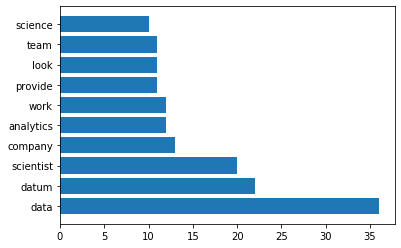

In [230]:
top_ten = dtm_df.sum().sort_values(ascending=False)[:10]
plt.barh(top_ten.index,top_ten.values);

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [233]:
data=[]
for _ in list(df.tokens):
  data.append(' '.join(_))

tf = TfidfVectorizer(max_features=5000,stop_words='english',min_df=5)

dtm=tf.fit_transform(data)
df_tf=pd.DataFrame(dtm.todense(),columns=tf.get_feature_names())
df_tf.head()

,advance,analysis,analytics,build,business,client,company,data,datum,decision,...,solution,solutions,statistical,statistics,support,team,technology,time,work,world
0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.376489,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
1,0.0,0.0,0.000000,0.452329,0.0,0.0,0.335105,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.489133
2,0.0,0.0,0.629933,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.776649,0.0,0.000000
3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.611804
4,0.0,0.0,0.319850,0.379995,0.0,0.0,0.000000,0.0,0.28703,0.0,...,0.0,0.0,0.0,0.0,0.0,0.305499,0.0,0.000000,0.0,0.000000


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [235]:
nn = NearestNeighbors(n_neighbors=5,algorithm='ball_tree')
nn.fit(dtm.todense())

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [236]:
ideal = ['AI and machine learning research']
ideal_job = tf.transform(ideal).todense()

nn.kneighbors(ideal_job)

(array([[0.74713378, 0.84359211, 0.87369942, 0.87369942, 0.9038279 ]]),
 array([[62, 77, 75, 16, 25]]))

In [243]:
df[df.index == 62]

,Title,Location,Company,Description,tokens
62,Senior Data Scientist,"New York, NY",HVH Precision Analytics,"Data science professional to design, implement...","[data, science, professional, design,, impleme..."


In [245]:
df[df.index == 77]

,Title,Location,Company,Description,tokens
77,Data Scientist,"Redmond, WA",Microsoft,"Do you like applying mathematics, statistics, ...","[like, apply, mathematics,, statistics,, machi..."


## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 